In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Let's submit a SQL (Structured Query Language) query to the SDSS DR18 database server (https://www.sdss.org/dr18/)

In [3]:
from astroquery.sdss import SDSS
zmin=0.015
zmax=0.05
sql=' SELECT \
      objid,ra,dec,petroMag_g,petroMag_r, \
      extinction_g,extinction_r,z,class \
      FROM SpecPhotoAll \
    WHERE \
      z > {:f} AND z < {:f} AND class = "GALAXY" \
      AND (ra between 140 and 240) and (dec between 0 and 50)'.format(zmin,zmax)
dr18=SDSS.query_sql(sql, data_release=18) 

print(len(dr18))

62710


C:\Users\n10480129\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


Determine distances (in Mpc) from Hubble law

In [4]:
c=3.e5  # km/s
h0=70   # km/s/Mpc
dist=dr18['z']*c/h0  # distance in Mpc

Determine absolute magnitudes while correcting for foreground extinction. The data used here includes:
 
- Petrosian magnitude or ([petroMag](https://skyserver.sdss.org/dr7/en/help/docs/algorithm.asp?key=mag_petro)), which is the apparent magnitude that is observed from the Earth. It represents the brightness of an object as seen from our location without any corrections.

- Extinction Corrections or ([extinction](https://skyserver.sdss.org/dr7/en/help/docs/algorithm.asp#E), which is a term that accounts for the extinction of light due to interstellar dust and other factors. Extinction causes the observed magnitude to be fainter than the intrinsic magnitude of the object.

By subtracting the extinction below, you are correcting for this effect, effectively converting the apparent magnitude to an unextincted apparent magnitude.

In [11]:
# in Mpc, m-M = 5 log d + 25
r = dr18['petroMag_r'] - dr18['extinction_r'] - 5 * np.log10(dist) - 25
print(len(r))
print(r)
# print(dr18['petroMag_r'])


62710
     petroMag_r    
-------------------
 -21.03669597005249
  -21.0362205055342
 -19.15294015575207
-19.154253935623956
 -20.99011023241497
  -17.3086480128081
-17.308095512555283
-20.992390613321515
-19.690629464955773
-19.692902671509167
                ...
-13.286271840416743
-13.480274586369056
-13.016396877461284
-13.374714266949312
-14.367191092538482
-12.584838337914663
 -13.01796944056053
                nan
 -13.67084110570249
                nan
-13.854560871773339
Length = 62710 rows


Let's plot an r-band luminosity function, but keep in mind it is uncorrected at this stage...


[0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 4.000e+00
 1.700e+01 3.100e+01 1.010e+02 2.450e+02 4.500e+02 7.330e+02 1.187e+03
 1.628e+03 2.096e+03 2.517e+03 2.978e+03 3.343e+03 3.519e+03 3.904e+03
 4.047e+03 4.273e+03 4.519e+03 4.659e+03 3.806e+03 3.277e+03 2.630e+03
 2.171e+03 1.673e+03 1.128e+03 7.010e+02 3.310e+02 2.070e+02]
[-25.   -24.75 -24.5  -24.25 -24.   -23.75 -23.5  -23.25 -23.   -22.75
 -22.5  -22.25 -22.   -21.75 -21.5  -21.25 -21.   -20.75 -20.5  -20.25
 -20.   -19.75 -19.5  -19.25 -19.   -18.75 -18.5  -18.25 -18.   -17.75
 -17.5  -17.25 -17.   -16.75 -16.5 ]


Text(0, 0.5, 'Number of galaxies (uncorrected)')

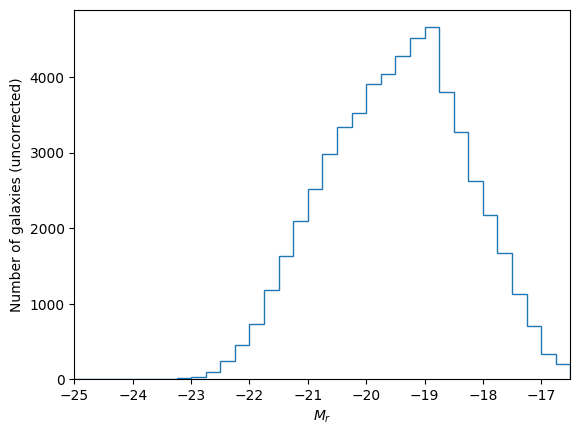

In [8]:
out=plt.hist(r,bins=np.arange(-25,-16.3,0.25),histtype='step')
for i in out:
    print(i)
plt.xlim(-25,-16.5)
plt.xlabel('$M_r$')
plt.ylabel('Number of galaxies (uncorrected)')

When you plot a histogram of galaxies by magnitude without any correction, you're essentially representing the observed distribution of galaxies in apparent magnitude space. This is similar to the situation seen in mass versus redshift plots, like in the ZFOURGE survey, where we saw low-mass galaxies can be underrepresented. Similarly, in magnitude histograms, we may miss the low-luminosity galaxies. This happens because an object's apparent magnitude is inversely affected by its distance from the observer. The farther away a galaxy is, the dimmer it appears. As a result, the histogram is skewed towards brighter magnitudes. To correct for this distance-induced bias, we need to account for the varying distances to galaxies in our sample. This is where the 1/Vmax method comes into play.


The 1/Vmax method aims to correct for these biases by accounting for the varying volumes within which galaxies can be observed. It calculates the maximum observable volume (Vmax) for each galaxy in your dataset, considering the selection limits of your survey. Then, it uses this volume as a weight to re-balance the galaxies in your histogram. In essence, it evens out the contributions of galaxies at different distances, allowing you to recover a more accurate representation of the intrinsic luminosity function. This correction is crucial for understanding the true distribution of galaxies' intrinsic properties and for making meaningful comparisons between different datasets and cosmological models.

 

Below, we calculate and visualise the volume of space probed by the survey as a function of absolute magnitude, taking into account magnitude limits and our redshift constraints. 

64.28571428571429 -16.270572368805432


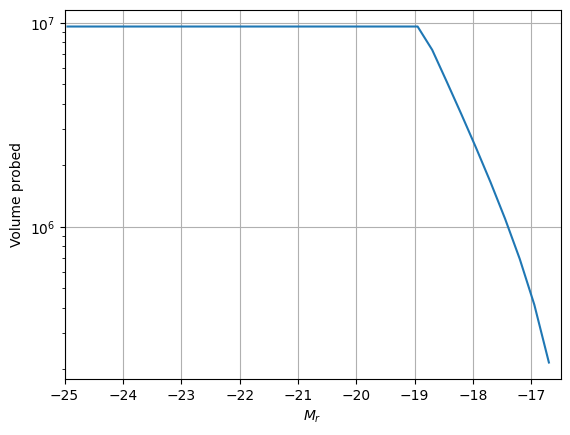

In [6]:
# center our histogram bins into mabs
mabs=out[1][0:-1]+0.05
# apparent magnitude limit of SDSS
mlim=17.77 
# use the mlim and mabs to determine the maximum distance
dmax=10**((mlim-mabs-25)/5)
# set a maximum distance of zmax=0.05 (based on our SQL selection criteria)
dmax[dmax>zmax*c/h0] = zmax*c/h0
# sets a minimum distance of zmin=0.015 (based on our SQL selection criteria)
dmin=.015*3.e5/70
print(dmin,mlim-5*np.log10(dmin)-25)
# volume probed as a function of mabs
vol = (dmax**3-dmin**3)

# Plot the volume probed as a function of mabs
plt.plot(mabs,vol)
plt.xlim(-25,-16.5)
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('Volume probed')
plt.grid()

We then use this volume to correct our histogram of galaxies by absolute magnitude.

Text(0, 0.5, '$\\phi$')

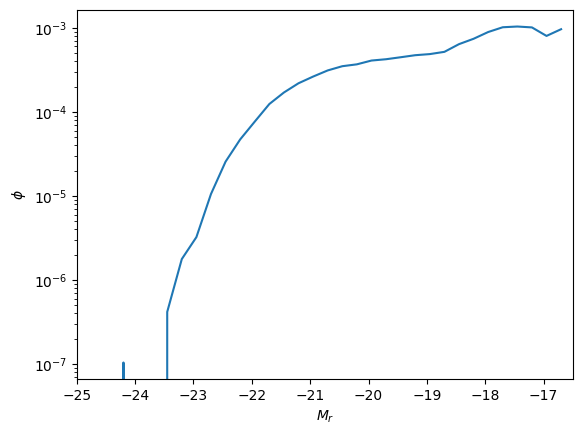

In [7]:
# corrected luminosity function
lf=out[0]/vol
plt.plot(mabs,lf)

plt.xlim(-25,-16.5)
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi$')

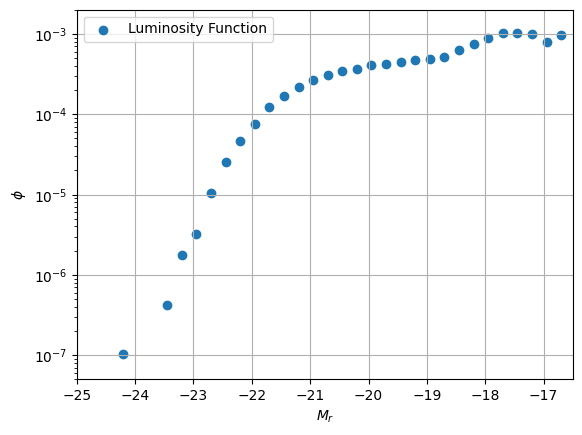

In [8]:
# create a scatter plot of the luminosity function
plt.scatter(mabs, lf, label='Luminosity Function')

plt.xlim(-25, -16.5)
plt.ylim(5e-8, 2e-3) 
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi$')
plt.grid(True)
plt.legend()
plt.show()

Pause here. Perhaps you want to export the data for analysis elsewhere? You can do this by copying the data to the clipboard using the below.

In [9]:

data_dict = {'Absolute Magnitude (M_r)': mabs, 'Weighted Counts': lf}
df = pd.DataFrame(data_dict)
# Copy the DataFrame to the clipboard
df.to_clipboard(index=False, header=True)

The Schechter function gives the number of galaxies per unit magnitude (or luminsoity), $ \phi(M)dM $. Fitting a Schechter function to the corrected luminosity function is a common approach. The Schechter function is a mathematical model that describes the distribution of magnitudes (or luminosities) of galaxies in the universe. It consists of three parameters: $ \phi * $ (the characteristic density), $ \alpha $ (the faint-end slope), and $ M* $ (the characteristic magnitude). By fitting a Schechter function to the observed luminosity function, we can characterize the intrinsic properties of galaxy populations, such as their distribution of magnitudes and the presence of different galaxy types.

The fitting process involves adjusting the Schechter parameters to best match the observed data, allowing us to estimate the characteristic values that describe the magnitude distribution in the studied region of the universe. For more information, be sure to review the provided [PDF and recording](https://canvas.qut.edu.au/courses/13966/pages/luminosity-functions?module_item_id=1472015). 

We now calculate and visualise a Schechter function fit to our luminosity function represented in magnitudes, both with and without data point filtering based on the Mabs value.

Schechter fit:
Mstar: -21.666267 
 alpha: -1.250501 
  phistar: 0.000338


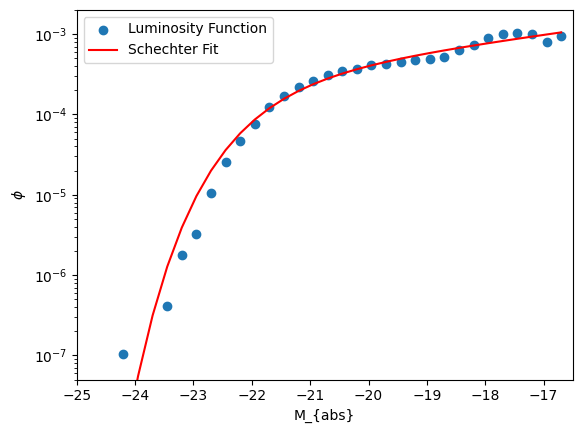

In [10]:
# Define the Schechter function
def schechter(m,mstar=-21,alpha=-1,phistar=1) :
    return phistar*10.**(-0.4*(alpha+1)*(m-mstar))*np.exp(-10.**(-0.4*(m-mstar)))
    
# Plot the corrected LF
plt.scatter(mabs, lf, label='Luminosity Function')
plt.xlim(-25, -16.5)
plt.ylim(5e-8, 2e-3)
plt.yscale('log')

# Do the fit with curve_fit
p0 = [-21, -1, 1]   # Starting guess for fit
from scipy.optimize import curve_fit
pars = curve_fit(schechter, mabs, lf, p0=p0)
print('Schechter fit:')
print('Mstar: {:f} \n alpha: {:f} \n  phistar: {:f}'.format(*pars[0]))

# Plot the Schechter fit
plt.plot(mabs, schechter(mabs, *pars[0]), 'r', label='Schechter Fit')
plt.xlabel('M_{abs}')
plt.ylabel('$\phi$')
plt.legend()
plt.show()

Schechter fit after removing brightest bins:
Mstar: -21.666280 
 alpha: -1.250502 
  phistar: 0.000338


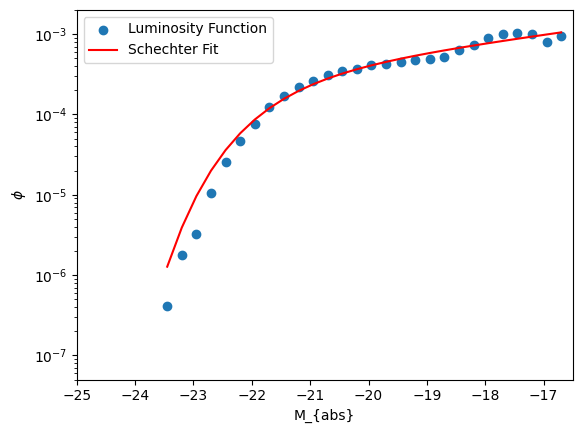

In [11]:
# Try again, removing data with Mabs < -23.5
plt.figure()
gd = np.where(mabs > -23.5)[0]
pars = curve_fit(schechter, mabs[gd], lf[gd], p0=p0)
print('Schechter fit after removing brightest bins:')
print('Mstar: {:f} \n alpha: {:f} \n  phistar: {:f}'.format(*pars[0]))

# Plot the corrected LF after removing brightest bins
plt.scatter(mabs[gd], lf[gd], label='Luminosity Function')
plt.xlim(-25, -16.5)
plt.ylim(5e-8, 2e-3)
plt.yscale('log')

# Plot the Schechter fit 
plt.plot(mabs[gd], schechter(mabs[gd], *pars[0]), 'r', label='Schechter Fit')
plt.xlabel('M_{abs}')
plt.ylabel('$\phi$')
plt.legend()
plt.show()

The parameter values provide insights into the characteristics of the galaxy population represented by our luminosity function. Here are some conclusions you can draw from these values:

Characteristic Magnitude ($ M* $ ): The $ M* $ value of approximately -21.67 represents the characteristic magnitude at which the luminosity function has a peak (does not necessarily coincide with the peak magnitude). This suggests that galaxies tend to cluster around this particular magnitude in the studied region of the universe.

Faint-End Slope ($ \alpha $): The $ \alpha $ value of approximately -1.25 describes the faint-end slope of the luminosity function. A value less than -1 indicates a steep drop in the number of faint galaxies, which is typical for galaxy populations where the number of low-luminosity galaxies is significantly smaller than brighter ones.

Characteristic Density ($ \phi * $): The $ \phi * $ value of approximately 0.000338 represents the characteristic density of galaxies per unit magnitude. It indicates the overall density of galaxies in the studied region, with lower values suggesting a sparser distribution.

The Schechter parameters allow you to quantify and describe the underlying distribution of galaxy magnitudes, shedding light on the characteristics and diversity of galaxy populations in the observed part of the universe. Understanding these parameters can serve as a foundation for further analysis. For example, you might consider splitting the sample between red and blue galaxies to investigate differences in the distribution between older and younger stellar populations. Exploring such distinctions can offer deeper insights into the evolutionary processes and demographics of galaxies in different cosmic environments. Additionally, you can use these parameters to make meaningful comparisons with theoretical models and observations from other surveys, contributing to a more comprehensive understanding of the universe's luminosity function.